In [ ]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy 

In [9]:
data=pd.read_csv(r"C:\vs\rideshare\dynamic_pricing.csv")
data.head()
     

,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride
0,90,45,Urban,Silver,13,4.47,Night,Premium,90,284.257273
1,58,39,Suburban,Silver,72,4.06,Evening,Economy,43,173.874753
2,42,31,Rural,Silver,0,3.99,Afternoon,Premium,76,329.795469
3,89,28,Rural,Regular,67,4.31,Afternoon,Premium,134,470.201232
4,78,22,Rural,Regular,74,3.77,Afternoon,Economy,149,579.681422


In [10]:
data.describe()

,Number_of_Riders,Number_of_Drivers,Number_of_Past_Rides,Average_Ratings,Expected_Ride_Duration,Historical_Cost_of_Ride
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000
mean,60.372000,27.076000,50.031000,4.257220,99.58800,372.502623
std,23.701506,19.068346,29.313774,0.435781,49.16545,187.158756
min,20.000000,5.000000,0.000000,3.500000,10.00000,25.993449
25%,40.000000,11.000000,25.000000,3.870000,59.75000,221.365202
50%,60.000000,22.000000,51.000000,4.270000,102.00000,362.019426
75%,81.000000,38.000000,75.000000,4.632500,143.00000,510.497504
max,100.000000,89.000000,100.000000,5.000000,180.00000,836.116419


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Number_of_Riders         1000 non-null   int64  
 1   Number_of_Drivers        1000 non-null   int64  
 2   Location_Category        1000 non-null   object 
 3   Customer_Loyalty_Status  1000 non-null   object 
 4   Number_of_Past_Rides     1000 non-null   int64  
 5   Average_Ratings          1000 non-null   float64
 6   Time_of_Booking          1000 non-null   object 
 7   Vehicle_Type             1000 non-null   object 
 8   Expected_Ride_Duration   1000 non-null   int64  
 9   Historical_Cost_of_Ride  1000 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 78.3+ KB
None

Summary Statistics:
       Number_of_Riders  Number_of_Drivers  Number_of_Past_Rides  \
count       1000.000000        1000.000000           1000.000000   
mean   

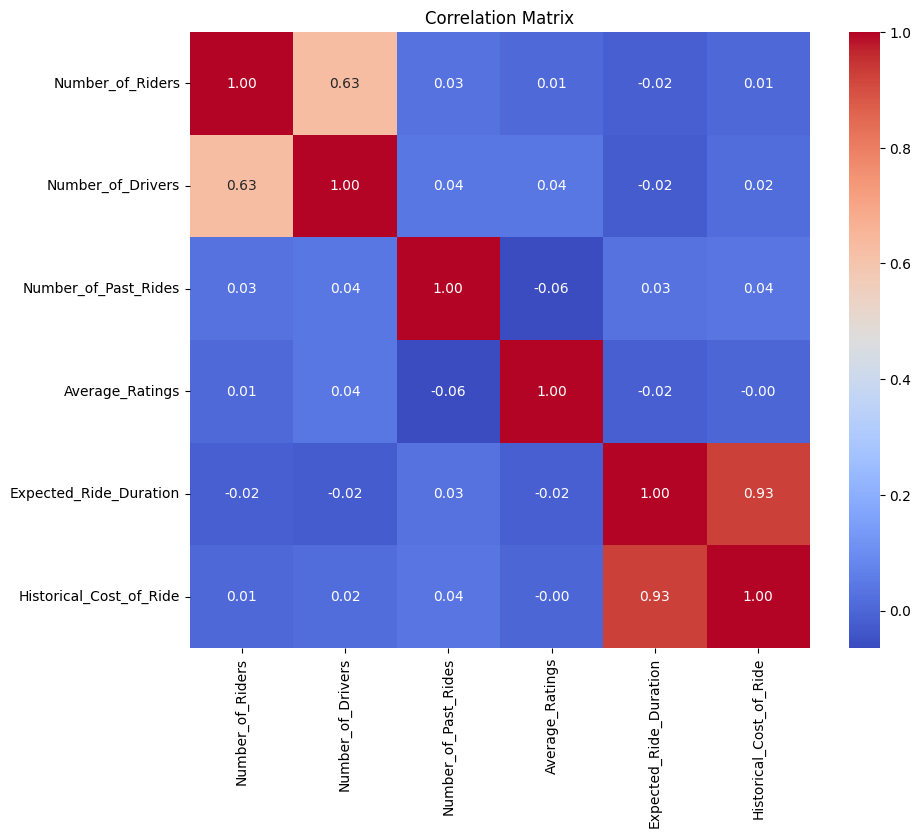

In [16]:
# Display basic information about the dataset
print("Dataset Info:")
print(data.info())

# Summary statistics for numerical features
print("\nSummary Statistics:")
print(data.describe())

# Check the unique values and their counts for categorical features
categorical_features = ['Location_Category', 'Customer_Loyalty_Status', 'Vehicle_Type', 'Time_of_Booking', 'Vehicle_Type']
for feature in categorical_features:
    print(f"\nUnique values for {feature}:")
    print(data[feature].value_counts())

# Exclude non-numeric columns before computing correlation matrix
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = data[numerical_features].corr()

# Correlation matrix for numerical features

print("\nCorrelation Matrix:")
print(correlation_matrix)

# Visualize correlation matrix (optional)
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

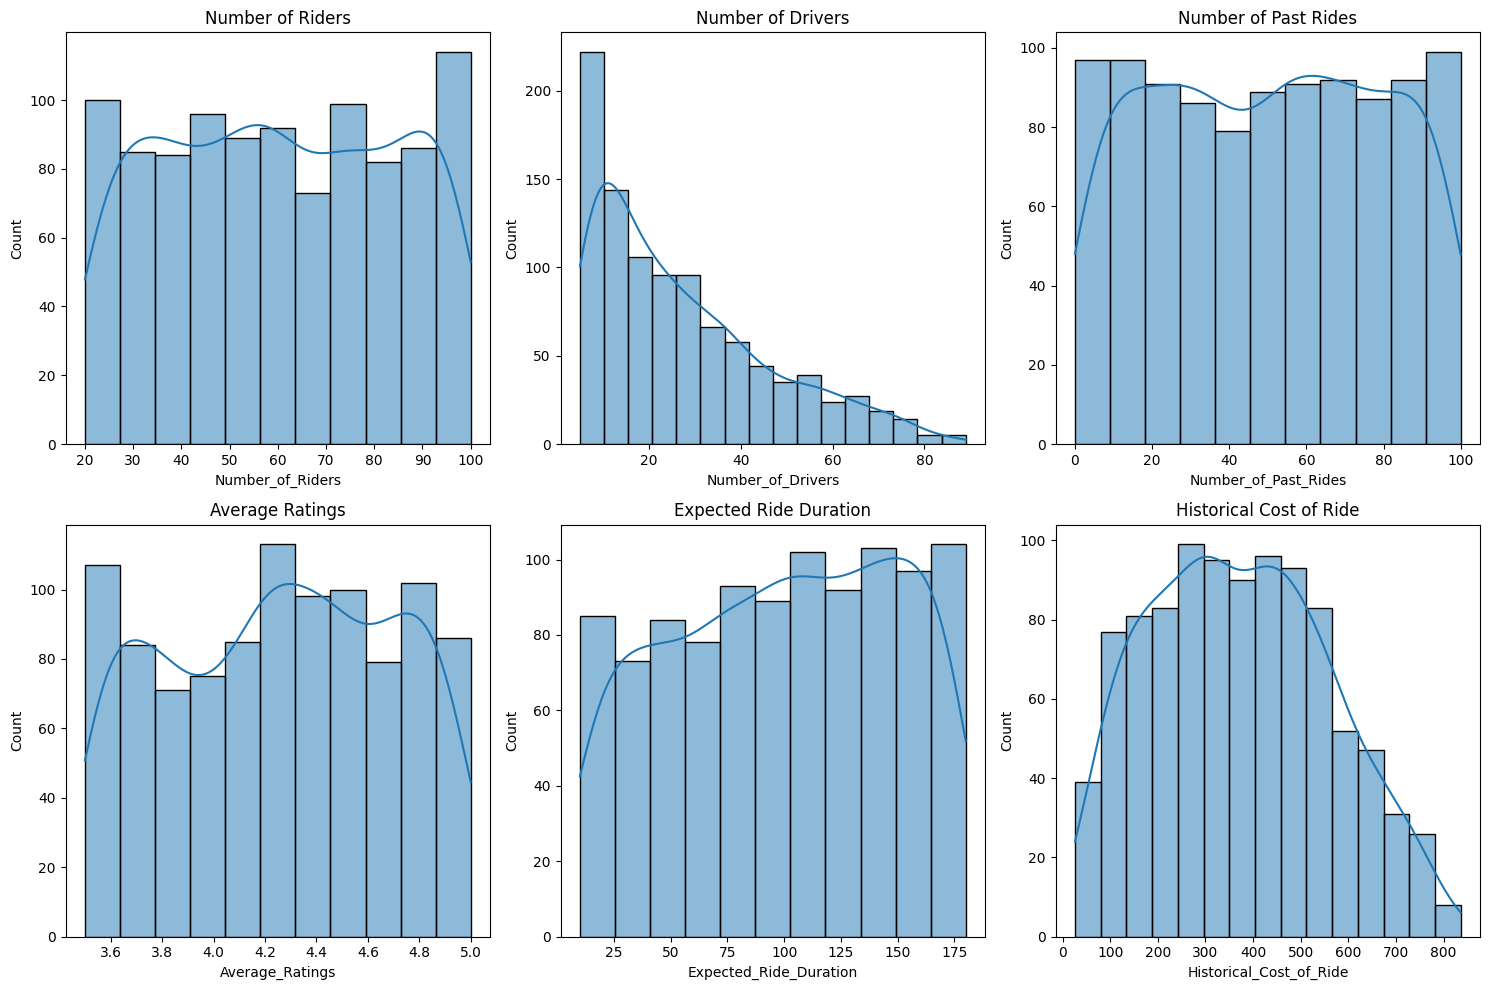

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Plot histograms for numerical features
plt.subplot(2, 3, 1)
sns.histplot(data['Number_of_Riders'], kde=True)
plt.title('Number of Riders')

plt.subplot(2, 3, 2)
sns.histplot(data['Number_of_Drivers'], kde=True)
plt.title('Number of Drivers')

plt.subplot(2, 3, 3)
sns.histplot(data['Number_of_Past_Rides'], kde=True)
plt.title('Number of Past Rides')

plt.subplot(2, 3, 4)
sns.histplot(data['Average_Ratings'], kde=True)
plt.title('Average Ratings')

plt.subplot(2, 3, 5)
sns.histplot(data['Expected_Ride_Duration'], kde=True)
plt.title('Expected Ride Duration')

plt.subplot(2, 3, 6)
sns.histplot(data['Historical_Cost_of_Ride'], kde=True)
plt.title('Historical Cost of Ride')

plt.tight_layout()
plt.show()

In [19]:
fig = px.scatter(data, x='Expected_Ride_Duration',
                 y='Historical_Cost_of_Ride',
                 title='Expected Ride Duration vs. Historical Cost of Ride',
                 trendline='ols')
fig.show()

In [20]:
import numpy as np

# Calculate demand_multiplier based on percentile for high and low demand
high_demand_percentile = 75
low_demand_percentile = 25

data['demand_multiplier'] = np.where(data['Number_of_Riders'] > np.percentile(data['Number_of_Riders'], high_demand_percentile),
                                     data['Number_of_Riders'] / np.percentile(data['Number_of_Riders'], high_demand_percentile),
                                     data['Number_of_Riders'] / np.percentile(data['Number_of_Riders'], low_demand_percentile))

# Calculate supply_multiplier based on percentile for high and low supply
high_supply_percentile = 75
low_supply_percentile = 25

data['supply_multiplier'] = np.where(data['Number_of_Drivers'] > np.percentile(data['Number_of_Drivers'], low_supply_percentile),
                                     np.percentile(data['Number_of_Drivers'], high_supply_percentile) / data['Number_of_Drivers'],
                                     np.percentile(data['Number_of_Drivers'], low_supply_percentile) / data['Number_of_Drivers'])

# Define price adjustment factors for high and low demand/supply
demand_threshold_high = 1.2  # Higher demand threshold
demand_threshold_low = 0.8  # Lower demand threshold
supply_threshold_high = 0.8  # Higher supply threshold
supply_threshold_low = 1.2  # Lower supply threshold

# Calculate adjusted_ride_cost for dynamic pricing
data['adjusted_ride_cost'] = data['Historical_Cost_of_Ride'] * (
    np.maximum(data['demand_multiplier'], demand_threshold_low) *
    np.maximum(data['supply_multiplier'], supply_threshold_high)
)

In [ ]:
#In the above code, we first calculated the demand multiplier by comparing the number of riders to percentiles representing high and low demand levels.
#If the number of riders exceeds the percentile for high demand, the demand multiplier is set as the number of riders divided by the high-demand percentile.
#Otherwise, if the number of riders falls below the percentile for low demand, the demand multiplier is set as the number of riders divided by the low-demand percentile.

#Next, we calculated the supply multiplier by comparing the number of drivers to percentiles representing high and low supply levels.
#If the number of drivers exceeds the low-supplypercentile, the supply multiplier is set as the high-supply percentile divided by the number of drivers.
#On the other hand, if the number of drivers is below the low-supply percentile, the supply multiplier is set as the low-supply percentile divided by the number of drivers.

#Finally, we calculated the adjusted ride cost for dynamic pricing.
#It multiplies the historical cost of the ride by the maximum of the demand multiplier and a lower threshold (demand_threshold_low),
#and also by the maximum of the supply multiplier and an upper threshold (supply_threshold_high).
#This multiplication ensures that the adjusted ride cost captures the combined effect of demand and supply multipliers, with the thresholds serving
#as caps or floors to control the price adjustments.

#Now let’s calculate the profit percentage we got after implementing this dynamic pricing strategy:

In [21]:
# Calculate the profit percentage for each ride
data['profit_percentage'] = ((data['adjusted_ride_cost'] - data['Historical_Cost_of_Ride']) / data['Historical_Cost_of_Ride']) * 100
# Identify profitable rides where profit percentage is positive
profitable_rides = data[data['profit_percentage'] > 0]

# Identify loss rides where profit percentage is negative
loss_rides = data[data['profit_percentage'] < 0]


import plotly.graph_objects as go

# Calculate the count of profitable and loss rides
profitable_count = len(profitable_rides)
loss_count = len(loss_rides)

# Create a donut chart to show the distribution of profitable and loss rides
labels = ['Profitable Rides', 'Loss Rides']
values = [profitable_count, loss_count]

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=0.4)])
fig.update_layout(title='Profitability of Rides (Dynamic Pricing vs. Historical Pricing)')
fig.show()
     

In [22]:
fig = px.scatter(data,
                 x='Expected_Ride_Duration',
                 y='adjusted_ride_cost',
                 title='Expected Ride Duration vs. Cost of Ride',
                 trendline='ols')
fig.show()

In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

def data_preprocessing_pipeline(data):
    #Identify numeric and categorical features
    numeric_features = data.select_dtypes(include=['float', 'int']).columns
    categorical_features = data.select_dtypes(include=['object']).columns

    #Handle missing values in numeric features
    data[numeric_features] = data[numeric_features].fillna(data[numeric_features].mean())

    #Detect and handle outliers in numeric features using IQR
    for feature in numeric_features:
        Q1 = data[feature].quantile(0.25)
        Q3 = data[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - (1.5 * IQR)
        upper_bound = Q3 + (1.5 * IQR)
        data[feature] = np.where((data[feature] < lower_bound) | (data[feature] > upper_bound),
                                 data[feature].mean(), data[feature])

    #Handle missing values in categorical features
    data[categorical_features] = data[categorical_features].fillna(data[categorical_features].mode().iloc[0])

    return data

In [24]:

data["Vehicle_Type"] = data["Vehicle_Type"].map({"Premium": 1,
                                           "Economy": 0})
     

In [25]:
#splitting data
from sklearn.model_selection import train_test_split
x = np.array(data[["Number_of_Riders", "Number_of_Drivers", "Vehicle_Type", "Expected_Ride_Duration"]])
y = np.array(data[["adjusted_ride_cost"]])

x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

# Reshape y to 1D array
y_train = y_train.ravel()
y_test = y_test.ravel()

# Training a random forest regression model
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
model.fit(x_train, y_train)

RandomForestRegressor()

In [26]:
def get_vehicle_type_numeric(vehicle_type):
    vehicle_type_mapping = {
        "Premium": 1,
        "Economy": 0
    }
    vehicle_type_numeric = vehicle_type_mapping.get(vehicle_type)
    return vehicle_type_numeric

# Predicting using user input values
def predict_price(number_of_riders, number_of_drivers, vehicle_type, Expected_Ride_Duration):
    vehicle_type_numeric = get_vehicle_type_numeric(vehicle_type)
    if vehicle_type_numeric is None:
        raise ValueError("Invalid vehicle type")

    input_data = np.array([[number_of_riders, number_of_drivers, vehicle_type_numeric, Expected_Ride_Duration]])
    predicted_price = model.predict(input_data)
    return predicted_price

# Example prediction using user input values
user_number_of_riders = 50
user_number_of_drivers = 25
user_vehicle_type = "Economy"
Expected_Ride_Duration = 30
predicted_price = predict_price(user_number_of_riders, user_number_of_drivers, user_vehicle_type, Expected_Ride_Duration)
print("Predicted price:", predicted_price)
     

Predicted price: [257.59494987]


In [27]:
import plotly.graph_objects as go

# Predict on the test set
y_pred = model.predict(x_test)

# Create a scatter plot with actual vs predicted values
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=y_test.flatten(),
    y=y_pred,
    mode='markers',
    name='Actual vs Predicted'
))

# Add a line representing the ideal case
fig.add_trace(go.Scatter(
    x=[min(y_test.flatten()), max(y_test.flatten())],
    y=[min(y_test.flatten()), max(y_test.flatten())],
    mode='lines',
    name='Ideal',
    line=dict(color='red', dash='dash')
))

fig.update_layout(
    title='Actual vs Predicted Values',
    xaxis_title='Actual Values',
    yaxis_title='Predicted Values',
    showlegend=True,
)

fig.show()